# U2L4.4


## L4.4 >> Challenge: make your own regression model
Using this data, build a regression model to predict property crimes. You can use the features you prepared in the previous assignment, new features of your own choosing, or a combination. The goal here is prediction rather than understanding mechanisms, so the focus is on creating a model that explains a lot of variance.

In [287]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.

import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [288]:
link = 'https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv'

indices_to_skip = np.array([0,1,2,353,354,355])

df = pd.read_csv(link,skiprows=indices_to_skip , header=1)

df.tail()


,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
343,Woodbury Town,"10,685",3,0,nan,0,2,1,541,9,529,3,nan
344,Woodridge Village,829,7,0,nan,0,0,7,17,8,9,0,0.000
345,Woodstock Town,"5,931",2,0,nan,0,0,2,58,13,45,0,nan
346,Yonkers,"199,134","1,036",6,nan,25,390,615,"2,368",470,"1,662",236,10.000
347,Yorktown Town,"36,643",15,0,nan,0,2,13,334,45,287,2,nan


In [616]:
df.shape

(348, 13)

In [289]:
df.dtypes

City                                       object
Population                                 object
Violent\ncrime                             object
Murder and\nnonnegligent\nmanslaughter      int64
Rape\n(revised\ndefinition)1              float64
Rape\n(legacy\ndefinition)2                object
Robbery                                    object
Aggravated\nassault                        object
Property\ncrime                            object
Burglary                                   object
Larceny-\ntheft                            object
Motor\nvehicle\ntheft                      object
Arson3                                    float64
dtype: object

In [357]:
# Not working:
new_cols = ['Murder','Rubberry']
def insert_cols(df):
    for i in range(len(new_cols)):
        #df[new_cols[i]]==np.nan
        return new_cols[i]
    
insert_cols(df)

'Murder'

### Replace ',' before converting to numeric:

In [290]:
cols = df.columns.drop(['City','Murder and\nnonnegligent\nmanslaughter','Rape\n(revised\ndefinition)1','Arson3'])

# Replace ',' before converting to numeric:
df[cols]=df[cols].replace(',*','',regex=True)

# Convert to numeric
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

In [293]:
df.describe()

,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
count,348.000,348.000,348.000,0.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,187.000
mean,40037.632,201.595,1.566,nan,5.865,72.902,121.261,792.606,119.684,637.017,35.905,1.872
std,450037.368,2815.269,18.304,nan,60.425,1031.033,1706.132,7659.725,924.949,6346.054,403.424,10.693
min,526.000,0.000,0.000,nan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,3003.000,2.000,0.000,nan,0.000,0.000,1.000,40.500,6.000,31.000,0.000,0.000
50%,7233.500,6.000,0.000,nan,0.000,1.000,4.000,112.500,17.500,94.000,2.000,0.000
75%,18427.500,22.000,0.000,nan,2.000,5.000,14.000,341.000,51.250,287.250,7.000,1.000
max,8396126.000,52384.000,335.000,nan,1112.000,19170.000,31767.000,141971.000,16606.000,117931.000,7434.000,132.000


### >>> std in `Population` is huge, this is an outlier that kills the analysis!

Drop values in "Population" that are outliers (more than 3 stdev from the mean):

In [328]:
q = df["Population"].quantile(0.99)
df2=df[df["Population"] < q].sort_values('Population', ascending=False)

In [329]:
df2.describe()

,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Robbery2
count,344.000,344.000,344.000,0.000,344.000,344.000,344.000,344.000,344.000,344.000,344.000,185.000,344.000
mean,14152.573,33.078,0.334,nan,1.939,10.378,20.427,316.703,53.863,253.366,9.474,1.124,0.174
std,18876.821,105.876,1.560,nan,5.662,36.304,64.049,602.881,134.721,454.847,28.851,4.758,0.380
min,526.000,0.000,0.000,nan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2983.250,2.000,0.000,nan,0.000,0.000,1.000,39.000,6.000,31.000,0.000,0.000,0.000
50%,7106.000,6.000,0.000,nan,0.000,1.000,4.000,111.500,17.000,93.500,2.000,0.000,0.000
75%,17889.250,21.000,0.000,nan,2.000,5.000,13.250,334.750,50.000,275.500,7.000,1.000,0.000
max,143834.000,1192.000,21.000,nan,75.000,400.000,696.000,6473.000,1781.000,4298.000,394.000,57.000,1.000


In [314]:
df2['Robbery'].value_counts().head(10)

0     139
1      56
2      25
3      23
4      14
5      10
16      7
6       6
13      5
11      5
Name: Robbery, dtype: int64

### Create a new column from `Robbery` that has binary data based on condition:

In [330]:
df2['Robbery2'] = np.where(df2['Robbery']>5, 1, 0)

# Check to make sure it worked.
print(df2['Robbery'].groupby(df2['Robbery2']).describe())

           count   mean    std   min    25%    50%    75%     max
Robbery2                                                         
0        267.000  1.052  1.426 0.000  0.000  0.000  2.000   5.000
1         77.000 42.714 67.647 6.000 10.000 16.000 31.000 400.000


### Use 'Larceny-\ntheft' column as a new member in the equation for predicting Property Crimes!

In [331]:
df2.loc[df['Murder and\nnonnegligent\nmanslaughter']>0,'Murder']=1
df2.loc[df['Murder and\nnonnegligent\nmanslaughter']==0,'Murder']=0

In [332]:
df2.columns

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3', 'Robbery2',
       'Murder'],
      dtype='object')

In [335]:
df2=df2.drop(['City', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
        'Aggravated\nassault', 'Burglary', 'Robbery',
       'Motor\nvehicle\ntheft', 'Arson3'],axis=1)

In [336]:
df2.dtypes

Population           int64
Property\ncrime      int64
Larceny-\ntheft      int64
Robbery2             int32
Murder             float64
dtype: object

-------------
$$ Property crime = \alpha + Population +  Murder + Robbery + Larceny$$

In [339]:
# Create a new df to hold only these variable:

prop_crime = df2[['Property\ncrime','Population','Murder','Robbery2','Larceny-\ntheft']]
prop_crime.head()

,Property crime,Population,Murder,Robbery2,Larceny- theft
310,6473,143834,1.000,1,4298
7,2118,118296,1.000,1,1882
3,4090,97956,1.000,1,3243
126,2303,96667,0.000,1,1925
267,567,87204,1.000,1,466


In [340]:
prop_crime.describe()

,Property crime,Population,Murder,Robbery2,Larceny- theft
count,344.000,344.000,344.000,344.000,344.000
mean,316.703,14152.573,0.131,0.224,253.366
std,602.881,18876.821,0.338,0.417,454.847
min,0.000,526.000,0.000,0.000,0.000
25%,39.000,2983.250,0.000,0.000,31.000
50%,111.500,7106.000,0.000,0.000,93.500
75%,334.750,17889.250,0.000,0.000,275.500
max,6473.000,143834.000,1.000,1.000,4298.000


### There are a few big outliers !
We need feature transformation: drop outliers, apply log, cube etc

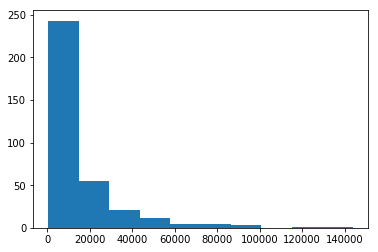

In [341]:
plt.hist(prop_crime['Population'],bins=10)
plt.show()

In [344]:
# Who are the biggest towns ?
prop_crime.sort_values('Population', ascending=False).head(5)

,Property crime,Population,Murder,Robbery2,Larceny- theft
310,6473,143834,1.000,1,4298
7,2118,118296,1.000,1,1882
3,4090,97956,1.000,1,3243
126,2303,96667,0.000,1,1925
267,567,87204,1.000,1,466


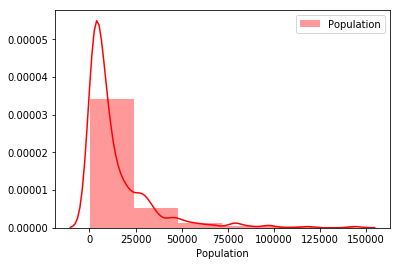

In [345]:
import seaborn as sns

sns.distplot( prop_crime["Population"] , color="red", label="Population",bins=6)
plt.legend()
plt.show()

###  a continuous and a categorical pair:
* boxplot

### Plot the 3 numerical features with boxplots for each 'Murder' situation.

In [346]:
# Restructure the data so we can use FacetGrid rather than making a boxplot
# for each variable separately.

df_murder_cols = prop_crime.columns.drop(['Robbery2'])
df_murder = prop_crime[df_murder_cols]
#df_murder.head(50)

In [347]:
df_murder = pd.melt(df_murder, id_vars=['Murder'])
#df_murder
#df_murder.variable.value_counts()

C:\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


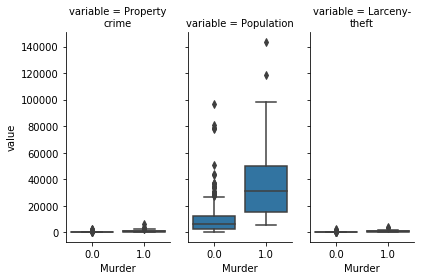

In [348]:
g = sns.FacetGrid(df_murder, col="variable", size=4, aspect=.5)
g = g.map(sns.boxplot, "Murder", "value")
plt.show()

* Because the three columns haven't been normalized, this plot is not yet relevant.

We'll do this step soon.

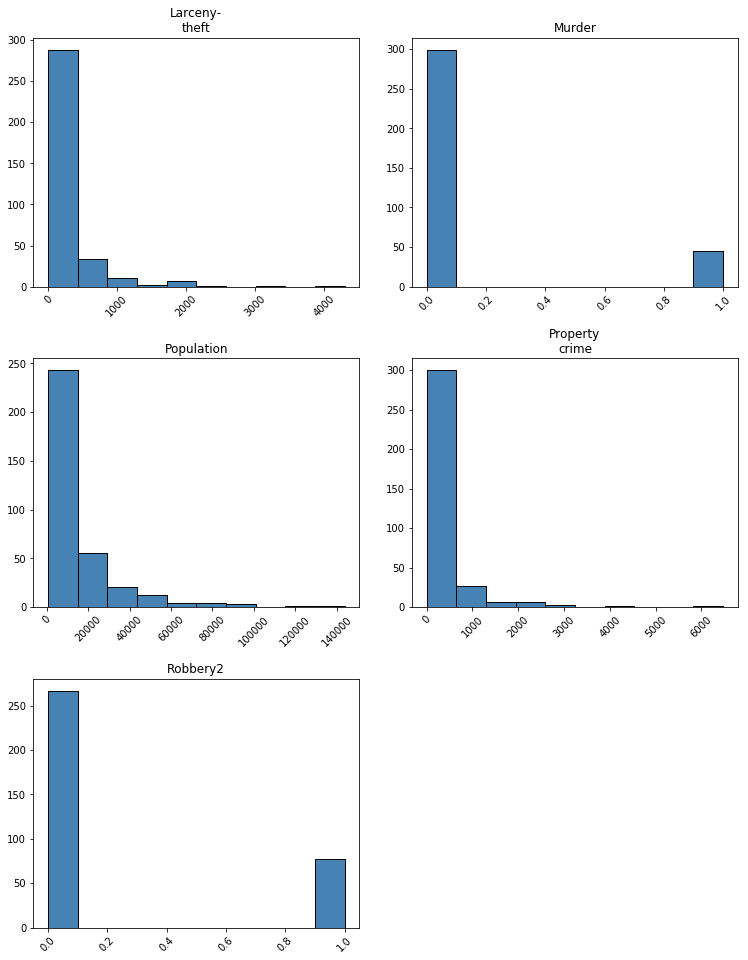

In [349]:
# Plot histograms to see what kind of distribution there is in each column:

fig = prop_crime.hist(bins=10,
                 color='steelblue',
                 edgecolor='black', linewidth=1.0,
                 xlabelsize=10, ylabelsize=10,
                 xrot=45, yrot=0,
                 figsize=(7,9),
                 grid=False)

plt.tight_layout(rect=(0, 0, 1.5, 1.5))   

* For numerical columns: they are skewed to the right.

Categorigal columns don't have any interpretation.

### Create the default pairplot for numerical columns to better see how data is groupping:

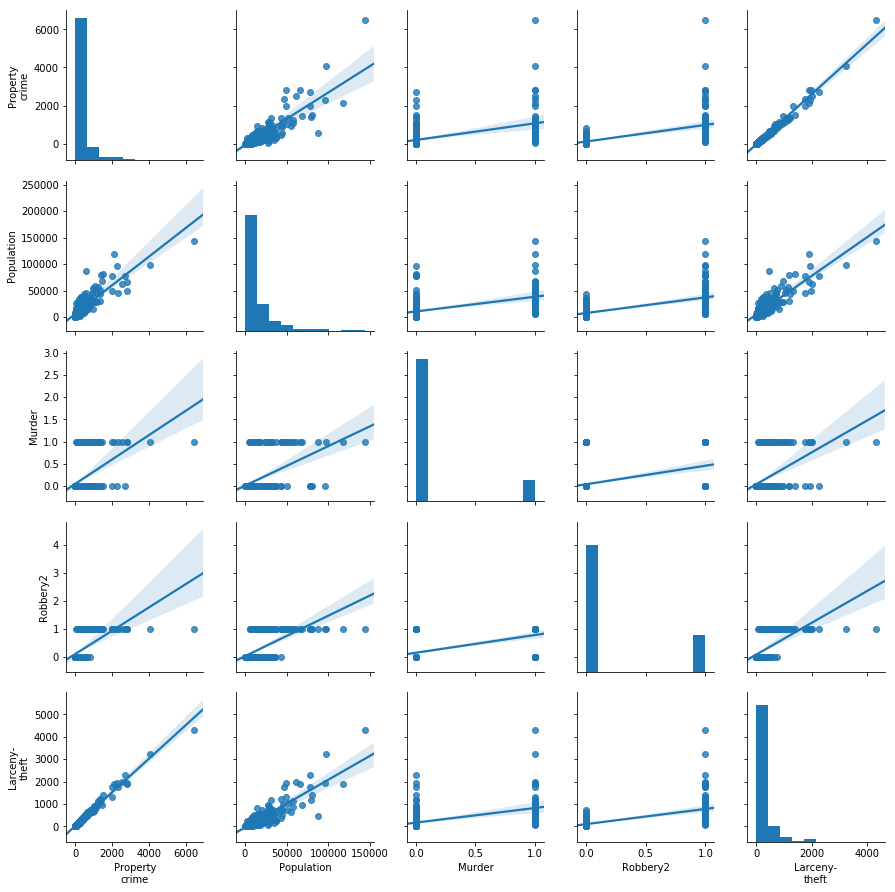

In [350]:
g=sns.pairplot(prop_crime.fillna(0) , diag_kind='hist' , kind='reg' )
plt.show()

### The histograms show no normal distribution. We should apply <u>feature transformations</u> on both numerical and categorical columns!

* The two categorical columns, Robbery and Murder, can be transformed into numeric representations with `getdummies`

In [351]:
# Making dummies.
# Also creating a data frame to hold our features.
features1 = pd.get_dummies(prop_crime['Murder'])
features1.columns=['Murder_False','Murder_True']

features2 = pd.get_dummies(prop_crime['Robbery2'])
features2.columns=['Robbery_False','Robbery_True']
features = pd.concat((features1 , features2),axis=1)
features.head()

,Murder_False,Murder_True,Robbery_False,Robbery_True
310,0,1,0,1
7,0,1,0,1
3,0,1,0,1
126,1,0,0,1
267,0,1,0,1


In [353]:
prop_crime2 =  pd.concat((prop_crime , features),axis=1)
prop_crime2 = prop_crime2.drop(['Murder','Robbery2'],1)

### Logarithm: 
Log of a variable is a common transformation method used to change the shape of distribution of the variable on a distribution plot. It is generally used for reducing right skewness of variables. Though, It can’t be applied to <b><u>zero</u></b> or negative values as well.

### From the three numerical columns, only 'Property crime' could have zero values, b/c the population can't be zero!

In [354]:

print(prop_crime2[prop_crime2['Property\ncrime']<=0])


     Property\ncrime  Population  Larceny-\ntheft  Murder_False  Murder_True  \
186                0        1688                0             1            0   
208                0        1622                0             1            0   
295                0        1437                0             1            0   
256                0        1274                0             1            0   
287                0         872                0             1            0   
319                0         615                0             1            0   

     Robbery_False  Robbery_True  
186              1             0  
208              1             0  
295              1             0  
256              1             0  
287              1             0  
319              1             0  


### >> we can drop these ZERO lines b/c population is very small and probably won't influence the analysis too much!

In [355]:
prop_crime2.is_copy = False # to deal with 'SettingWithCopyWarning'.
prop_crime2.drop(prop_crime2[prop_crime2['Property\ncrime']<=0].index , inplace=True)

In [356]:
prop_crime2.columns

Index(['Property\ncrime', 'Population', 'Larceny-\ntheft', 'Murder_False',
       'Murder_True', 'Robbery_False', 'Robbery_True'],
      dtype='object')

In [371]:
prop_crime_log = prop_crime2[['Property\ncrime','Population','Larceny-\ntheft']].apply(np.log)
prop_crime_log.sort_values(by='Larceny-\ntheft').head(5)

,Property crime,Population,Larceny- theft
128,0.000,7.348,-inf
227,0.000,7.000,0.000
95,0.000,8.691,0.000
12,0.693,6.489,0.693
44,0.693,6.636,0.693


In [373]:
prop_crime_log['Larceny-\ntheft'].replace(-np.inf, 0, inplace=True)

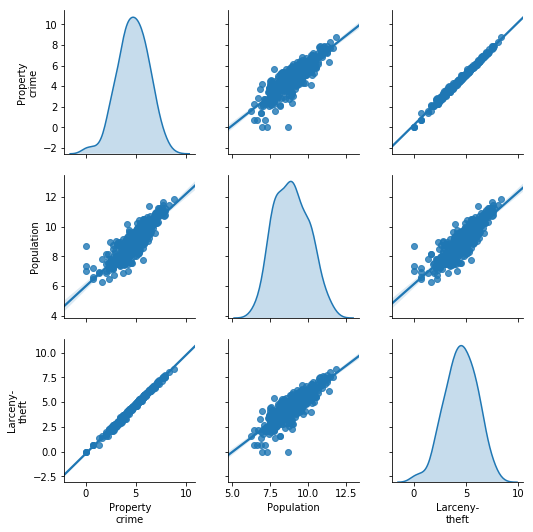

In [375]:
g=sns.pairplot(prop_crime_log, diag_kind='kde' , kind='reg'
               #, plot_kws=dict(edgecolor="k", linewidth=0.5)
               , diag_kws=dict(shade=True)
              )
plt.show()

### Now the histograms look more <u>normal</u> and the scatter plots are more linearly oriented!

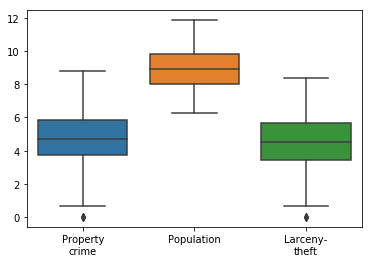

In [376]:
sns.boxplot( data = prop_crime_log )
plt.show()

###  StandardScaler or MinMaxScaler.

Also these scalers are good for normal data.

When we want to change the scale of a variable or standardize the values of a variable for better understanding. While this transformation is a must if you have data in different scales, this transformation <u>does not change the shape</u> of the variable distribution

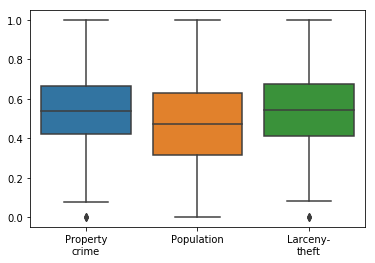

In [377]:
import pandas as pd
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler,quantile_transform
scaler = MinMaxScaler()

b_fit_scaled = scaler.fit_transform(prop_crime_log)

index = ['Row'+str(i) for i in range(1, len(b_fit_scaled)+1)]
df_fit_scaled = pd.DataFrame(b_fit_scaled, index=prop_crime_log.index , columns = prop_crime_log.columns )

sns.boxplot( data = df_fit_scaled )
plt.show()


### Already have dropped values in "Population" that are outliers (more than 3 stdev from the mean)


### Create a correlation matrix between continuous variables:

                 Property\ncrime  Population  Larceny-\ntheft  Murder_False  \
Property\ncrime            1.000       0.863            0.992        -0.488   
Population                 0.863       1.000            0.881        -0.496   
Larceny-\ntheft            0.992       0.881            1.000        -0.483   
Murder_False              -0.488      -0.496           -0.483         1.000   
Murder_True                0.488       0.496            0.483        -1.000   
Robbery_False             -0.601      -0.652           -0.619         0.514   
Robbery_True               0.601       0.652            0.619        -0.514   

                 Murder_True  Robbery_False  Robbery_True  
Property\ncrime        0.488         -0.601         0.601  
Population             0.496         -0.652         0.652  
Larceny-\ntheft        0.483         -0.619         0.619  
Murder_False          -1.000          0.514        -0.514  
Murder_True            1.000         -0.514         0.514  
Robbery

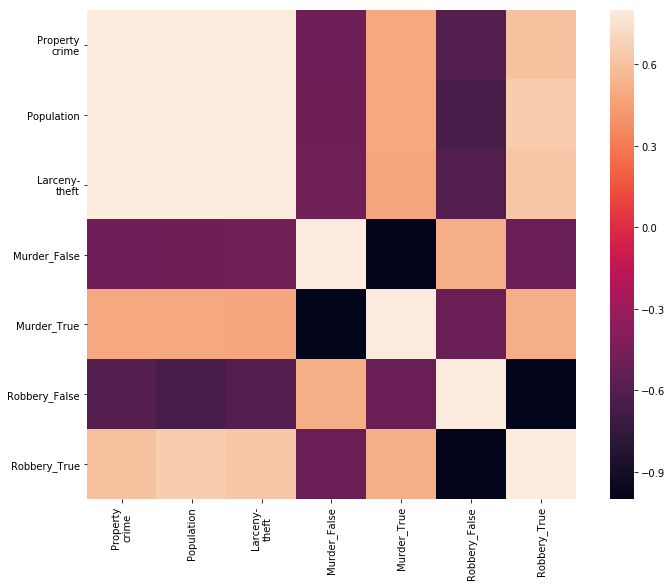

In [378]:
corrmat = prop_crime2.corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

* It looks like there is a lot of correlation. Population and population_squared are redundant.

In [379]:
X_cols = prop_crime2.columns.drop(['Property\ncrime' ])
X_cols

Index(['Population', 'Larceny-\ntheft', 'Murder_False', 'Murder_True',
       'Robbery_False', 'Robbery_True'],
      dtype='object')

In [380]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = prop_crime2['Property\ncrime'].values.reshape(-1, 1)
X = prop_crime2[X_cols]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[-1.43956980e-03  1.37080757e+00 -2.04073446e+01  2.04073446e+01
   1.55091182e+01 -1.55091182e+01]]

Intercept: 
 [-3.92244605]

R-squared:
0.9850619370775062


### Assumptions of Multivariable Linear Regression
For regression to work its magic, inputs to the model need to be consistent with four assumptions:

1. Assumption one: linear relationship = ok
* Assumption two: multivariate normality
* Assumption three: homoscedasticity
* Assumption four: low multicollinearity ~ok

### 2.Assumption two: multivariate normality
The error from the model (calculated by subtracting the model-predicted values from the real outcome values) should be normally distributed. Since ordinary least squares regression models are fitted by choosing the parameters that best minimize error, skewness or outliers in the error can result in serious miss-estimations.

Outliers or skewness in error can often be traced back to outliers or skewness in data.

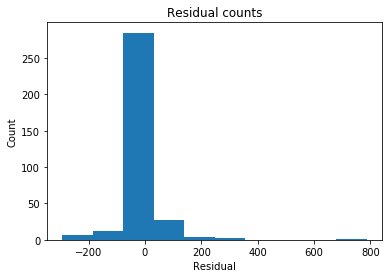

In [381]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = prop_crime2['Property\ncrime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

### 3.Assumption three: homoscedasticity
The distribution of your error terms (its "scedasticity"), should be consistent for all predicted values, or homoscedastic.

For example, if your error terms aren't consistently distributed and you have more variance in the error for large outcome values than for small ones, then the confidence interval for large predicted values will be too small because it will be based on the average error variance. This leads to overconfidence in the accuracy of your model's predictions.

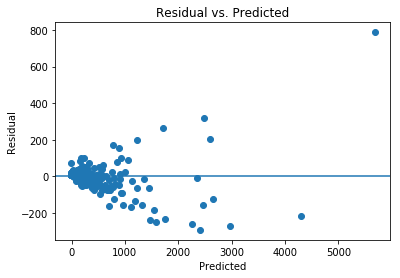

In [382]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# Hm... looks a bit concerning.